### Differential Equation

$\frac{\mathrm{d}\Psi}{\mathrm{d}x} = -(x + \frac{1 + 3x^2}{1 + x + x^3})\Psi + x^3 + 2x + x^2 \frac{1 + 3x^2}{1 + x + x^3},$

$\Psi(0) = 1, x \in [0, 2]$

In [1]:
from typing import List, Callable
import autograd.numpy as np

from neural_network import init_weights, forward
from optimizers import gradient_descent, adam
from activation_functions import elu, sigmoid, tanh, arctan
from plotting_tools import plot_ode, plot_system_ode

In [2]:
PSI_0 = np.array([1])


def derivative(x, psi) -> np.ndarray:
    """Example #1 derivative.

    Args:
        x: The input vector
        psi: The function vector

    Returns:
        Value of psi's partial derivatives at x.
    """
    psi_dot = (
        -(x + (1 + 3 * x**2) / (1 + x + x**3)) * psi
        + x**3
        + 2 * x
        + x**2 * (1 + 3 * x**2) / (1 + x + x**3)
    )
    return psi_dot


def analytical_solution(x):
    """Analytical solution to example #1.
    Args:
        x: The input vector

    Returns:
        Value of psi at x.
    """
    return np.exp(-(x**2) / 2) / (1 + x + x**3) + x**2


def trial_solution(
    t: np.array, weights_list: List[List[np.array]], activation_fns: List[Callable]
) -> np.ndarray:
    """Calculates the trial solution of the system of DEs.

    Args:
        t: The input vector
        weights_list: A list of weights and biases for each neural networks

    Returns:
        A NumPy array of the trial solution of the system of DEs
        dimension (len(weights_list), len(t))
    """
    f = [
        forward(t, weights_list[i], activation_fns).reshape(t.size)
        for i in range(len(weights_list))
    ]
    return np.array([PSI_0[i] + t * f[i] for i in range(len(weights_list))])

### Training

Iteration:  0
 7.300423969070878
Iteration:  1
 7.017519366124693
Iteration:  2
 6.734790095718235
Iteration:  3
 6.452329587237243
Iteration:  4
 6.170246086710354
Iteration:  5
 5.888667105099254
Iteration:  6
 5.607745204121111
Iteration:  7
 5.3276655684311915
Iteration:  8
 5.048655985944669
Iteration:  9
 4.771000103736392
Iteration:  10
 4.49505517679762
Iteration:  11
 4.221276023905934
Iteration:  12
 3.95024760321262
Iteration:  13
 3.6827295760761194
Iteration:  14
 3.419717463216136
Iteration:  15
 3.1625263927178264
Iteration:  16
 2.912904448541679
Iteration:  17
 2.673181588736244
Iteration:  18
 2.4464527426286673
Iteration:  19
 2.2367705168944543
Iteration:  20
 2.0492669821647675
Iteration:  21
 1.8900184871763728
Iteration:  22
 1.7653404668225527
Iteration:  23
 1.680225421651539
Iteration:  24
 1.6361431447459314
Iteration:  25
 1.629364470171458
Iteration:  26
 1.6512410818444636
Iteration:  27
 1.6905177894251864
Iteration:  28
 1.7361599762258386
Iteration:  29

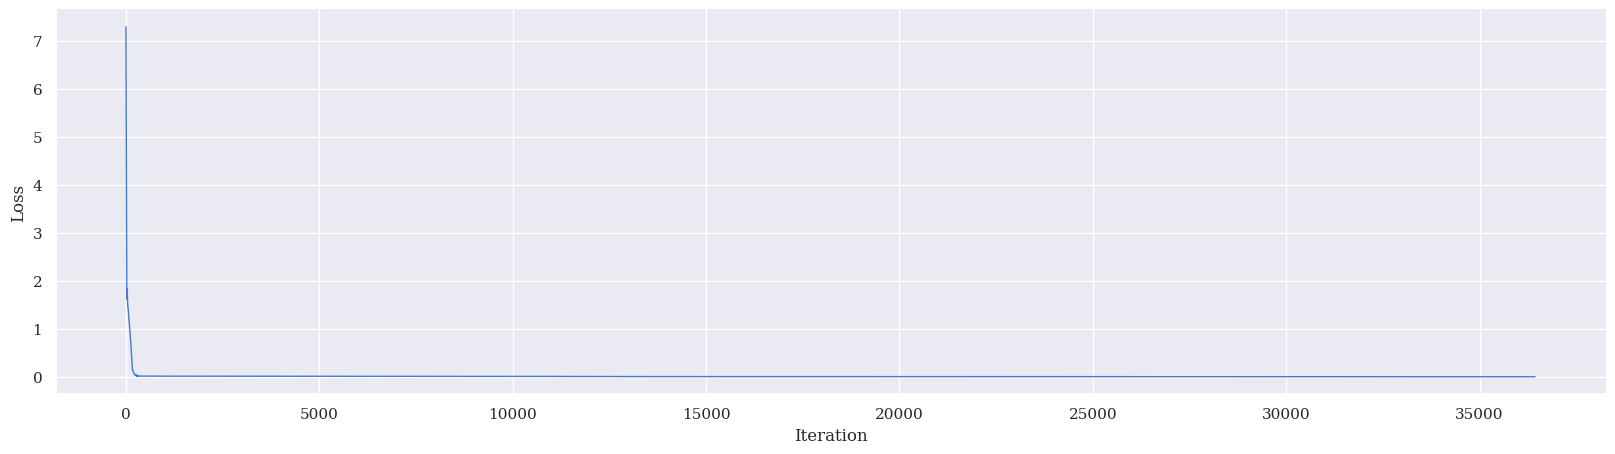

In [6]:
def train():
    t = np.arange(0, 2, 0.2)
    hidden_sizes = np.array([10])
    activation_fns = [sigmoid] * (len(hidden_sizes)) + [lambda x: x]
    nn_weights = init_weights(1, hidden_sizes, 1)
    adam(
        t,
        [nn_weights],
        activation_fns,
        trial_solution,
        derivative,
        num_iters=50000,
        step_size=0.01,
    )

    return nn_weights, activation_fns


nn_weights, activation_fns = train()

### Evaluating Results

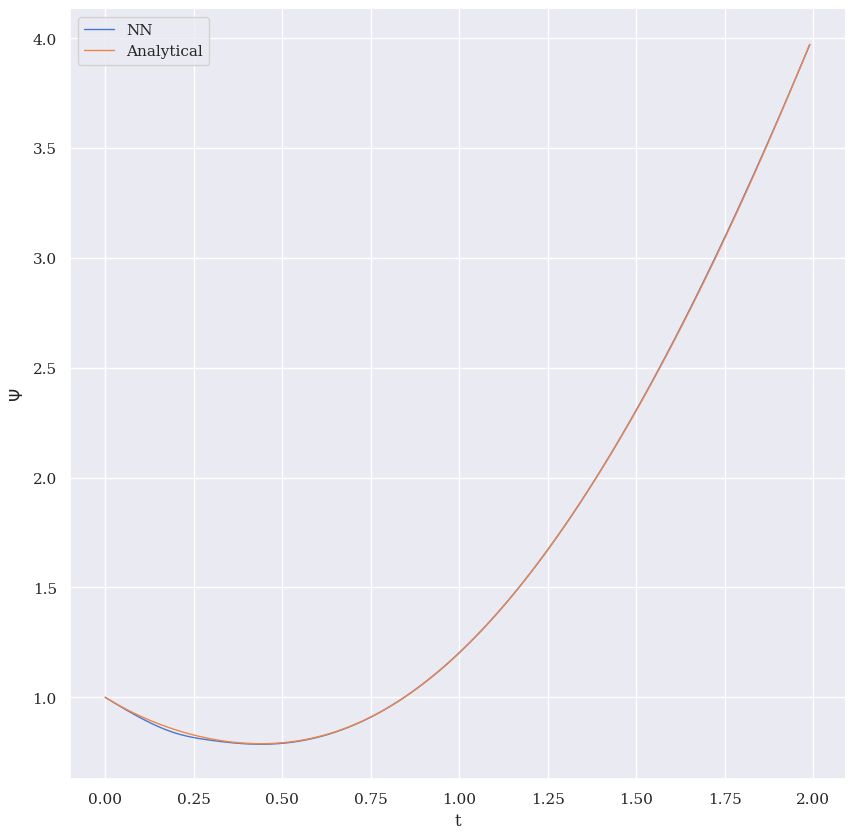

In [10]:
t = np.arange(0, 2, 0.01)
res = trial_solution(t, [nn_weights], activation_fns)
an_sol = analytical_solution(t)
plot_ode(t, res, an_sol)